```
From: https://github.com/ksatola
Version: 0.0.1

TODOs
1. 

```

# Supervised Wrapper-Type Feature Selection Methods
Feature selection refers to techniques that select a subset of the most relevant features (columns) for a dataset. Fewer features can allow machine learning algorithms to run more efficiently (less space or time complexity) and be more effective. Some machine learning algorithms can be misled by irrelevant input features, resulting in worse predictive performance.

`Recursive Feature Elimination (RFE)`, is a popular feature selection algorithm because it is easy to configure and use and because it is effective at selecting those features (columns) in a training dataset that are more or most relevant in predicting the target variable.

RFE is a `wrapper-type` feature selection algorithm. This means that a different machine learning algorithm is given and used in the core of the method, is wrapped by RFE, and used to help select features. This is in contrast to `filter-based` feature selections that score each feature and select those features with the largest (or smallest) score. Technically, RFE is a wrapper-style feature selection algorithm that also uses filter-based feature selection internally. RFE works by searching for a subset of features by starting with all features in the training dataset and successfully removing features until the desired number remains. This is achieved by fitting the given machine learning algorithm used in the core of the model, ranking features by importance, discarding the least important features, and re-fitting the model. This process is repeated until a specified number of features remains. Features are scored either using the provided machine learning model (e.g. some algorithms like decision trees offer importance scores) or by using a statistical method.

There are two important configuration options when using RFE: 
- the choice in the number of features to select and 
- the choice of the algorithm used to help choose features. 

Both of these hyperparameters can be explored, although the performance of the method is not strongly dependent on these hyperparameters being configured well.

The RFE method is available via the [RFE](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html) class in scikit-learn. Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a `coef_` attribute or through a `feature_importances_` attribute. Then, the least important features are pruned from current set of features.That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

In [75]:
# Connect with underlying Python code
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, '../src')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
from datasets import (
    get_dataset
)

from feature_selection import (
    select_features
)

In [77]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [78]:
import sklearn
print(sklearn.__version__)

0.23.2


**RFE is a transform**. To use it, first the class is configured with the chosen algorithm specified via the `estimator` argument and the number of features to select via the `n_features_to_select` argument. The algorithm must provide a way to calculate important scores, such as a decision tree. The algorithm used in RFE does not have to be the algorithm that is fit on the selected features; different algorithms can be used.

Once configured, **the class must be fit on a training dataset** to select the features by calling the `fit()` function. After the class is fit, the choice of input variables can be seen via the `support_` attribute that provides a True or False for each input variable. It can then be applied to the training and test datasets by calling the `transform()` function.

It is common to use [k-fold cross-validation](https://machinelearningmastery.com/k-fold-cross-validation/) to evaluate a machine learning algorithm on a dataset. When using cross-validation, it is good practice to perform data transforms like RFE as part of a [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) to avoid data leakage.

---

## RFE for Classification

We can evaluate an RFE feature selection algorithm on a binary classification dataset. We will use a [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) to choose features and set the number of features to five. We will then fit a new DecisionTreeClassifier model on the selected features.

We will evaluate the model using `repeated stratified k-fold cross-validation`, with three repeats and 10 folds. We will report the `mean` and `standard deviation` of the `accuracy` of the model across all repeats and folds.

In [79]:
# target = 'survived'
df = get_dataset('titanic3')

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df_num = df.select_dtypes(include=numerics)
df_num = df_num.drop('body', axis=1)
df_num.dropna(inplace=True)
df_num.head()

,pclass,survived,age,sibsp,parch,fare
0,1,1,29.0000,0,0,211.3375
1,1,1,0.9167,1,2,151.5500
2,1,0,2.0000,1,2,151.5500
3,1,0,30.0000,1,2,151.5500
4,1,0,25.0000,1,2,151.5500


In [80]:
# Return a single boolean if there is any cell that is missing in a DataFrame
df_num.isna().any().any()

False

In [81]:
# This dataset contains no missing data
df_num.shape

(1045, 6)

In [82]:
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

In [83]:
y = df_num[['survived']]
X = df_num.drop(columns=['survived'])

# Normally we should also split into train-test and perform RFE on train only

In [84]:
# Create pipeline
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=3)
model = DecisionTreeClassifier()
pipeline = Pipeline(steps=[
    ('select', rfe), 
    ('model', model),
])

In [85]:
# Evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
n_scores = cross_val_score(pipeline, X, y.values.ravel(), scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

In [86]:
n_scores

array([0.65714286, 0.66666667, 0.59047619, 0.63809524, 0.62857143,
       0.69230769, 0.61538462, 0.63461538, 0.55769231, 0.66346154,
       0.57142857, 0.63809524, 0.61904762, 0.60952381, 0.64761905,
       0.71153846, 0.60576923, 0.53846154, 0.63461538, 0.59615385,
       0.66666667, 0.59047619, 0.62857143, 0.64761905, 0.6       ,
       0.58653846, 0.67307692, 0.57692308, 0.63461538, 0.625     ])

In [87]:
# Report performance
print(f'Accuracy: mean {mean(n_scores):.3f} and std. dev. ({std(n_scores):.3f})')

Accuracy: mean 0.625 and std. dev. (0.039)


In [88]:
# See the selected columns (should be done on a train dataset)
rfe.fit(X, y)
rfe.support_

array([False,  True,  True, False,  True])

In [89]:
X.columns

Index(['pclass', 'age', 'sibsp', 'parch', 'fare'], dtype='object')

In [90]:
cols = ['age', 'sibsp', 'fare']

Age, sibsp and fare were selected

When using RFE, we may be interested to know which features were selected and which were removed. This can be achieved by reviewing the attributes of the fit RFE object (or fit RFECV object). The `support_` attribute reports true or false as to which features in order of column index were included and the `ranking_` attribute reports the relative ranking of features in the same order.

In [74]:
# Summarize all features
for i in range(X.shape[1]):
    print(f'Column: {X.columns[i]}, Selected {rfe.support_[i]}, Rank: {rfe.ranking_[i]:.3f}3f')

Column: pclass, Selected False, Rank: 3.0003f
Column: age, Selected True, Rank: 1.0003f
Column: sibsp, Selected True, Rank: 1.0003f
Column: parch, Selected False, Rank: 2.0003f
Column: fare, Selected True, Rank: 1.0003f


We can also use the RFE model pipeline as a final model and make predictions for classification. First, the RFE and model are fit on all available data, then the `predict()` function can be called to make predictions on new data.

In [17]:
# Fit the model on all available data but to selected by RFE features
pipeline.fit(X[cols], y.values.ravel())

Pipeline(steps=[('select',
                 RFE(estimator=DecisionTreeClassifier(),
                     n_features_to_select=3)),
                ('model', DecisionTreeClassifier())])

In [18]:
# Make a prediction for one example
data = {'age': [29], 'sibsp': [0], 'fare': [210]}
df_pred = pd.DataFrame.from_dict(data)
df_pred.head()

,age,sibsp,fare
0,29,0,210


In [19]:
yhat = pipeline.predict(df_pred)
print(f'Predicted Class: {yhat}')

Predicted Class: [1]


---

## RFE for Regression
As we did with the last section, we will evaluate the pipeline with a decision tree using `repeated k-fold cross-validation`, with three repeats and 10 folds. We will report the `mean absolute error (MAE)` of the model across all repeats and folds. **The scikit-learn library makes the MAE negative so that it is maximized instead of minimized**. This means that larger negative MAE are better and a perfect model has a MAE of 0.

In [91]:
df_num = get_dataset('boston_housing')
df_num.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [92]:
# Return a single boolean if there is any cell that is missing in a DataFrame
df_num.isna().any().any()

False

In [93]:
# This dataset contains no missing data
df_num.shape

(506, 14)

In [94]:
y = df_num[['medv']]
X = df_num.drop(columns=['medv'])

# Normally we should also split into train-test and perform RFE on train only

In [95]:
from sklearn.tree import DecisionTreeRegressor

# Create pipeline
rfe = RFE(estimator=DecisionTreeRegressor(), n_features_to_select=5)
model = DecisionTreeRegressor()
pipeline = Pipeline(steps=[
    ('select', rfe), 
    ('model', model),
])

In [96]:
from sklearn.model_selection import RepeatedKFold

# Evaluate model
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
n_scores = cross_val_score(pipeline, X, y.values.ravel(), scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')

In [97]:
# Report performance
print(f'MAE: mean {mean(n_scores):.3f} and std. dev. ({std(n_scores):.3f})')

MAE: mean -3.165 and std. dev. (0.572)


In [98]:
# See the selected columns (should be done on a train dataset)
rfe.fit(X, y)
rfe.support_

array([ True, False, False, False,  True,  True, False,  True, False,
       False, False, False,  True])

In [99]:
X.columns

Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'b', 'lstat'],
      dtype='object')

In [100]:
cols = ['crim', 'nox', 'rm', 'dis', 'lstat']

When using RFE, we may be interested to know which features were selected and which were removed. This can be achieved by reviewing the attributes of the fit RFE object (or fit RFECV object). The `support_` attribute reports true or false as to which features in order of column index were included and the `ranking_` attribute reports the relative ranking of features in the same order.

In [101]:
# Summarize all features
for i in range(X.shape[1]):
    print(f'Column: {X.columns[i]}, Selected {rfe.support_[i]}, Rank: {rfe.ranking_[i]:.3f}3f')

Column: crim, Selected True, Rank: 1.0003f
Column: zn, Selected False, Rank: 8.0003f
Column: indus, Selected False, Rank: 6.0003f
Column: chas, Selected False, Rank: 7.0003f
Column: nox, Selected True, Rank: 1.0003f
Column: rm, Selected True, Rank: 1.0003f
Column: age, Selected False, Rank: 3.0003f
Column: dis, Selected True, Rank: 1.0003f
Column: rad, Selected False, Rank: 9.0003f
Column: tax, Selected False, Rank: 2.0003f
Column: ptratio, Selected False, Rank: 4.0003f
Column: b, Selected False, Rank: 5.0003f
Column: lstat, Selected True, Rank: 1.0003f


In [30]:
# Fit the model on all available data but to selected by RFE features
pipeline.fit(X[cols], y.values.ravel())

Pipeline(steps=[('select',
                 RFE(estimator=DecisionTreeRegressor(),
                     n_features_to_select=5)),
                ('model', DecisionTreeRegressor())])

In [31]:
# Make a prediction for one example
data = {'crim': [0.006], 'nox': [0.5], 'rm': [6], 'dis': [4], 'lstat': [5]}
df_pred = pd.DataFrame.from_dict(data)
df_pred.head()

,crim,nox,rm,dis,lstat
0,0.006,0.5,6,4,5


In [32]:
yhat = pipeline.predict(df_pred)
print(f'Predicted: {yhat}')

Predicted: [24.6]


---

## RFE Hyperparameters
An important hyperparameter for the RFE algorithm is the `number of features to select`. In practice, we cannot know the best number of features to select with RFE; instead, it is good practice to test different values. The example below demonstrates selecting different numbers of features from 2 to 5 on the synthetic binary classification dataset.

In [38]:
# target = 'survived'
df = get_dataset('titanic3')

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df_num = df.select_dtypes(include=numerics)
df_num = df_num.drop('body', axis=1)
df_num.dropna(inplace=True)
df_num.head()

,pclass,survived,age,sibsp,parch,fare
0,1,1,29.0000,0,0,211.3375
1,1,1,0.9167,1,2,151.5500
2,1,0,2.0000,1,2,151.5500
3,1,0,30.0000,1,2,151.5500
4,1,0,25.0000,1,2,151.5500


In [39]:
y = df_num[['survived']]
X = df_num.drop(columns=['survived'])

In [51]:
# Get a list of models to evaluate
def get_models():
    models = dict()
    for i in range(2, 6):
        rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=i)
        model = DecisionTreeClassifier()
        models[str(i)] = Pipeline(steps=[
            ('s',rfe),
            ('m',model),
        ])
    return models

In [52]:
# Evaluate a give model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

In [53]:
# Get the models to evaluate
models = get_models()

In [54]:
# Evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X, y.values.ravel())
    results.append(scores)
    names.append(name)
    print(f'{name} {mean(scores):.3f} ({std(scores):.3f})')

2 0.623 (0.036)
3 0.625 (0.041)
4 0.633 (0.040)
5 0.633 (0.039)


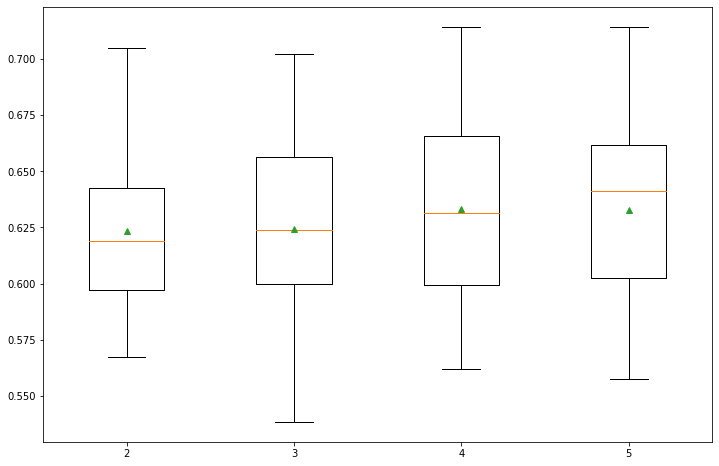

In [55]:
# Plot model performance for comparison
fig, ax = plt.subplots(figsize=(12, 8))
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

It is also possible to **automatically select the number of features chosen by RFE** using [RFECV](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html) class. This can be achieved by performing cross-validation evaluation of different numbers of features as we did above and automatically selecting the number of features that resulted in the best mean score.

The `RFECV` is configured just like the RFE class regarding the choice of the algorithm that is wrapped. Additionally, the minimum number of features to be considered can be specified via the `min_features_to_select` argument (defaults to 1) and we can also specify the type of cross-validation and scoring to use via the `cv` (defaults to 5) and `scoring` arguments (uses accuracy for classification).

In [56]:
from sklearn.feature_selection import RFECV

In [110]:
# Create pipeline
rfecv = RFECV(estimator=DecisionTreeClassifier())
model = DecisionTreeClassifier()
pipeline = Pipeline(steps=[
    ('s',rfecv),
    ('m',model),
])

# Evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

# Report performance
print(f'Accuracy {mean(scores):.3f} ({std(scores):.3f})')

Accuracy 0.632 (0.033)


In [114]:
rfecv.fit(X, y)

print(f"Optimal number of features : {rfecv.n_features_}")

Optimal number of features : 2


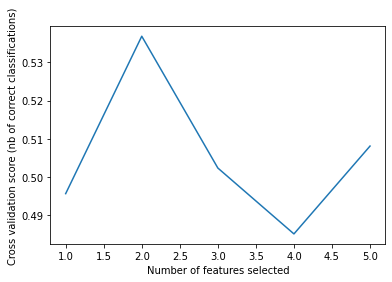

In [113]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

## Choose Best Algorithm for RFE
There are many algorithms that can be used in the core RFE, as long as they provide some indication of variable importance. Most decision tree algorithms are likely to report the same general trends in feature importance, but this is not guaranteed. It might be helpful to explore the use of different algorithms wrapped by RFE.

In [102]:
# Explore the algorithm wrapped by RFE
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from matplotlib import pyplot

In [103]:
# Get the dataset
# target = 'survived'
df = get_dataset('titanic3')

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df_num = df.select_dtypes(include=numerics)
df_num = df_num.drop('body', axis=1)
df_num.dropna(inplace=True)
df_num.head()

,pclass,survived,age,sibsp,parch,fare
0,1,1,29.0000,0,0,211.3375
1,1,1,0.9167,1,2,151.5500
2,1,0,2.0000,1,2,151.5500
3,1,0,30.0000,1,2,151.5500
4,1,0,25.0000,1,2,151.5500


In [104]:
y = df_num[['survived']]
X = df_num.drop(columns=['survived'])

In [105]:
# Get a list of models to evaluate
def get_models():
    models = dict()
    
    # lr
    rfe = RFE(estimator=LogisticRegression(), n_features_to_select=5)
    model = DecisionTreeClassifier()
    models['lr'] = Pipeline(steps=[('s',rfe), ('m',model)])
    
    # perceptron
    rfe = RFE(estimator=Perceptron(), n_features_to_select=5)
    model = DecisionTreeClassifier()
    models['per'] = Pipeline(steps=[('s',rfe), ('m',model)])

    # cart
    rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=5)
    model = DecisionTreeClassifier()
    models['cart'] = Pipeline(steps=[('s',rfe), ('m',model)])

    # rf
    rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=5)
    model = DecisionTreeClassifier()
    models['rf'] = Pipeline(steps=[('s',rfe), ('m',model)])

    # gbm
    rfe = RFE(estimator=GradientBoostingClassifier(), n_features_to_select=5)
    model = DecisionTreeClassifier()
    models['gbm'] = Pipeline(steps=[('s',rfe), ('m',model)])
    return models

In [106]:
# Evaluate a give model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

In [107]:
# Get the models to evaluate
models = get_models()

In [108]:
# Evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X, y.values.ravel())
    results.append(scores)
    names.append(name)
    print(f'{name} {mean(scores):.3f} ({std(scores):.3f})')

lr 0.634 (0.035)
per 0.634 (0.034)
cart 0.632 (0.038)
rf 0.635 (0.039)
gbm 0.632 (0.033)


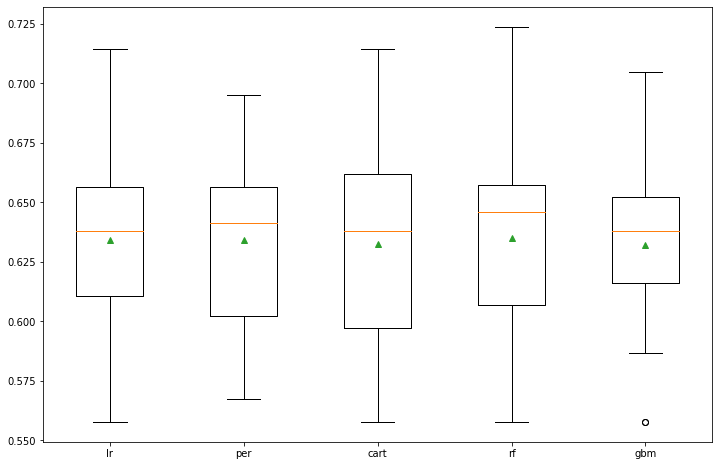

In [109]:
# Plot model performance for comparison
fig, ax = plt.subplots(figsize=(12, 8))
plt.boxplot(results, labels=names, showmeans=True)
plt.show()